# Image classifier for 3 vs 7

Adapted from code in lesson 4.

In [80]:
# Setup fastbook
import fastbook
fastbook.setup_book()

In [81]:
# Import libraries
from fastai.vision.all import *
from fastbook import *

In [82]:
# Load data
print("Loading: {0}".format(URLs.MNIST_SAMPLE))
data_path = untar_data(URLs.MNIST_SAMPLE)
print("Save to: {0}".format(data_path))

# Tell fastbook.Path to use current path as base directory
Path.BASE_PATH = data_path

Loading: https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz
Save to: /home/jupyter/.fastai/data/mnist_sample


In [83]:
import pathlib

def pprint_path(path):
    slash = ""
    name = "..."
    if isinstance(path, pathlib.Path):
        slash = "/" if path.is_dir() else ""
        name = path.name
    return "{name}{slash}".format(name=name, slash=slash)

def pprint_dir(path, indent=0, max_depth=3, max_per_dir=4):
    print("{indent}{path}".format(path=pprint_path(path), indent="  " * indent))
    
    if indent < max_depth and path.is_dir():
        # Get paths and truncate to max_per_dir
        paths = list(path.iterdir())
        if len(paths) > max_per_dir:
            paths = paths[:max_per_dir] + ["..."]
        
        # If next indent level equals max_depth then print all contents on 1 line
        if indent + 1 == max_depth:
            print("{indent}{paths}".format(indent="  " * (indent + 1),
                                           paths=" ".join(pprint_path(p) for p in paths)))
            return
        
        for p in paths:
            pprint_dir(p, indent+1)

In [84]:
pprint_dir(data_path, max_depth=4)

mnist_sample/
  train/
    7/
      1899.png 15818.png 14403.png 22871.png ...
    3/
      7.png 54413.png 35407.png 47605.png ...
  labels.csv
  valid/
    7/
      1133.png 1919.png 4736.png 9300.png ...
    3/
      5724.png 7476.png 2020.png 8050.png ...


In [33]:
def paths_in_dir(path):
    return path.ls().sorted()

# Load data
threes_train = paths_in_dir(data_path/'train/3')
threes_valid = paths_in_dir(data_path/'valid/3')
sevens_train = paths_in_dir(data_path/'train/7')
sevens_valid = paths_in_dir(data_path/'valid/7')

print("Data sizes:")
print("train:")
print("   3: {0} 7: {1}".format(len(threes_train), len(sevens_train)))
print("validation:")
print("   3: {0} 7: {1}".format(len(threes_valid), len(sevens_valid)))

Data sizes:
train:
   3: 6131 7: 6265
validation:
   3: 1010 7: 1028


In [100]:
# Take a peek
num_samples = 2

imgs = [Image.open(p) for p in random.sample(threes_train, num_samples)]
imgs += [Image.open(p) for p in random.sample(threes_valid, num_samples)]
imgs += [Image.open(p) for p in random.sample(sevens_train, num_samples)]
imgs += [Image.open(p) for p in random.sample(sevens_valid, num_samples)]

display(*imgs)

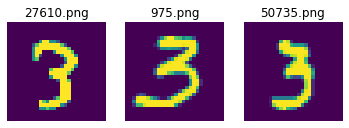

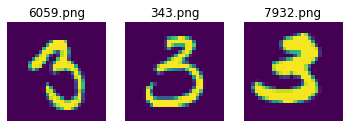

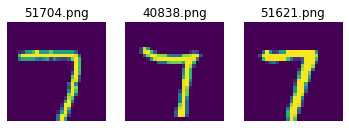

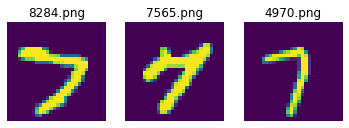

In [118]:
def show_imgs(imgs, num_samples):
    samples = random.sample(imgs, num_samples)
    imgs = [Image.open(p) for p in samples]
    filenames = [p.name for p in samples]
    show_images(imgs, titles=filenames, imsize=2)

show_imgs(threes_train, 3)
show_imgs(threes_valid, 3)
show_imgs(sevens_train, 3)
show_imgs(sevens_valid, 3)

In [104]:
# Convert to tensors
def path_to_tensor(*paths):
    return [tensor(Image.open(p)) for p in paths]

# Convert image files into tensors
threes_train_tensors = path_to_tensor(*threes_train)
threes_valid_tensors = path_to_tensor(*threes_valid)
sevens_train_tensors = path_to_tensor(*sevens_train)
sevens_valid_tensors = path_to_tensor(*sevens_valid)

In [120]:
# Stack together for efficient processing
threes_train_stacked = torch.stack(threes_train_tensors)
threes_valid_stacked = torch.stack(threes_valid_tensors)
sevens_train_stacked = torch.stack(sevens_train_tensors)
sevens_valid_stacked = torch.stack(sevens_valid_tensors)

threes_train_stacked.shape, threes_valid_stacked.shape, sevens_train_stacked.shape, sevens_valid_stacked.shape

(torch.Size([6131, 28, 28]),
 torch.Size([1010, 28, 28]),
 torch.Size([6265, 28, 28]),
 torch.Size([1028, 28, 28]))

In [124]:
def to_dataset(threes, sevens):
    num_threes = threes.shape[0]
    num_sevens = sevens.shape[0]
    
    instances = torch.cat([threes, sevens]).float() / 255 # Squish all pixel values to between 0 and 1.
    instances = instances.view(-1, 28*28)  # Convert from 28 x 28 grid of pixels to single row
    
    # create a list of tensors representing the label
    labels = tensor([1] * num_threes + [0] * num_sevens).unsqueeze(1)
    
    dset = list(zip(instances, labels))
    
    print("dset: {0} x: {1} y: {2}".format(len(dset), instances.shape, labels.shape))
    
    return dset, instances, labels
    
dset, instances, labels = to_dataset(threes_train_stacked, sevens_train_stacked)
dset_valid, instances_valid, labels_valid = to_dataset(threes_valid_stacked, sevens_valid_stacked)

dset: 12396 x: torch.Size([12396, 784]) y: torch.Size([12396, 1])
dset: 2038 x: torch.Size([2038, 784]) y: torch.Size([2038, 1])


In [220]:
# Define basic linear model.
class LinearModel(object):
    
    def __init__(self, weights, bias):
        self.weights = weights
        self.bias = bias
        
        self.weights.requires_grad_()
        self.bias.requires_grad_()
        
    def classify(self, x):
        return x @ self.weights + self.bias
    
# Stochastic gradient descent means use gradient descent on a single training
# example at a time. (Batch) Gradient Descent means use the whole training
# set.
class StochasticGradientDescent(object):

    def __init__(self, model, lr, loss):
        self.model = model
        self.lr = lr  # learning rate
        self.loss = loss
        
    def step(self, x, labels):
        predictions = self.model.classify(x)
        
        loss = self.loss(predictions, labels)
        # Auto compute gradient and store in .grad (of all tensors which
        # have .requires_grad_() called.)
        loss.backward()
        
        # Update in direction of gradient
        self.model.weights.data -= self.model.weights.grad * self.lr
        self.model.weights.grad.zero_()  # Clear out gradient
        
        self.model.bias.data -= self.model.bias.grad * self.lr
        self.model.bias.grad.zero_()  # Clear out gradient
        
def sigmoid(x):
    return 1. / (1. + torch.exp(-x))

def mnist_loss(predictions, labels):
    predictions = predictions.sigmoid()
    loss = torch.where(labels == 1, 1 - predictions, predictions)
    return loss.mean()

def batch_accuracy(xb, yb):
    predictions = xb.sigmoid()
    correct = (predictions > 0.5) == yb
    return correct.float().mean()

def validate_epoch(m, valid_dl):
    accs = [batch_accuracy(m.classify(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [221]:
dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(dset_valid, batch_size=256)

In [223]:
lr = 1.0

weights = torch.randn(28*28)
bias = torch.randn(1)

m = LinearModel(weights, bias)
sgd = StochasticGradientDescent(m, lr, mnist_loss)

for i in range(100):
    for x, label in dl:
        sgd.step(x, label)
    print(validate_epoch(m, valid_dl), end=' ')

0.634 0.6382 0.6342 0.6275 0.6205 0.6039 0.5943 0.5917 0.5797 0.5746 0.5681 0.5644 0.5577 0.5554 0.5521 0.5497 0.546 0.5428 0.5409 0.5381 0.5343 0.5304 0.529 0.5276 0.5272 0.5263 0.5258 0.5238 0.5219 0.5214 0.5204 0.5196 0.5196 0.5196 0.5196 0.5183 0.5183 0.5179 0.5174 0.5159 0.5159 0.5159 0.5155 0.5155 0.5132 0.5127 0.5127 0.5118 0.5113 0.5108 0.5113 0.5113 0.5113 0.5108 0.5099 0.5099 0.509 0.509 0.5081 0.5081 0.5071 0.5071 0.5071 0.5071 0.5071 0.5071 0.5071 0.5071 0.5071 0.5067 0.5071 0.5071 0.5071 0.5071 0.5071 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5076 0.5081 0.5081 0.5081 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 0.5077 

In [191]:
sigmoid(tensor([37.]))

tensor([1.])

In [141]:
len(first(valid_dl)[1])

256

In [194]:
torch.randn(3)

tensor([-0.4520, -0.0352,  0.1652])